# Objectives

1. Estimate Clock Model
1. Filter Outliers
    - Plot Prune Compare: Divtree
    - Plot Prune Compare: Timetree
1. Add Clock Model to Dataframe

NOTE: Filter outliers after clock model estimated?

---
# Setup

## Modules

In [1]:
# Bio
import treetime
from Bio import Phylo

# Plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
sns.set_style('whitegrid')

# Stats
import pandas as pd

# System IO
import dill
import copy
import os
import io
import sys

## Variables

In [2]:
from config import *

# Custom script variables
SCRIPT_NAME = "clock"
PREV_SCRIPT_NAME = "parse_tree"

WILDCARDS = snakemake.wildcards
# TESTING
# WILDCARDS = ["all", "chromosome", "5"]
READS_ORIGIN = WILDCARDS[0]
LOCUS_NAME = WILDCARDS[1]
MISSING_DATA = WILDCARDS[2]

NAME_COL = "Name"

# Clock model params
N_IQD = 3
MAX_ITER = 3
TC = "skyline"


## Paths

In [3]:
project_dir = os.getcwd()
# TESTING
# project_dir = os.path.dirname(os.path.dirname(project_dir))
config_dir = os.path.join(project_dir, "config")
results_dir = os.path.join(project_dir, "results")


outdir       = os.path.join(results_dir, SCRIPT_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA),)
tree_dill    = os.path.join(results_dir, PREV_SCRIPT_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA),PREV_SCRIPT_NAME + ".phylo.obj")
tree_df_dill = os.path.join(results_dir, PREV_SCRIPT_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), PREV_SCRIPT_NAME + ".df.obj")
tree_df_path = os.path.join(results_dir, PREV_SCRIPT_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), PREV_SCRIPT_NAME + ".tsv")
aln_path     = os.path.join(results_dir,"snippy_multi",READS_ORIGIN,"snippy-core_{}.snps.filter{}.aln".format(LOCUS_NAME, MISSING_DATA))

# Auspice
auspice_latlon_path = os.path.join(results_dir, PREV_SCRIPT_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), PREV_SCRIPT_NAME + "_latlon.tsv")
auspice_colors_path = os.path.join(results_dir, PREV_SCRIPT_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), PREV_SCRIPT_NAME + "_colors.tsv")
auspice_config_path = os.path.join(config_dir, "auspice_config.json")
auspice_remote_dir_path = os.path.join(project_dir, "auspice/")

print("tree_dill:\t", tree_dill)
print("tree_df_dill:\t", tree_df_dill)
print("aln path:\t", aln_path)
print("auspice_latlon_path:", auspice_latlon_path)
print("auspice_colors_path:", auspice_colors_path)
print("auspice_config_path:", auspice_config_path)
print("auspice_remote_dir_path:", auspice_remote_dir_path)
print("outdir:", outdir)

# Create output directory if it doesn't exist
while not os.path.exists(outdir):
    os.makedirs(outdir)   
    
SCRIPT_NAME = "clock_model"

tree_dill:	 /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/parse_tree/all/chromosome_filter5/parse_tree.phylo.obj
tree_df_dill:	 /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/parse_tree/all/chromosome_filter5/parse_tree.df.obj
aln path:	 /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/snippy_multi/all/snippy-core_chromosome.snps.filter5.aln
auspice_latlon_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/parse_tree/all/chromosome_filter5/parse_tree_latlon.tsv
auspice_colors_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/parse_tree/all/chromosome_filter5/parse_tree_colors.tsv
auspice_config_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/config/auspice_config.json
auspice_remote_dir_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/auspice/
outdir: /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/clock/all/chromosome_filter5


## Import Tree

In [4]:
with open(tree_dill, "rb") as infile:
    tree = dill.load(infile)
tree.ladderize(reverse=False)

## Import Dataframe

In [5]:
with open(tree_df_dill, "rb") as infile:
    tree_df = dill.load(infile)
tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number
Name,,,,,,,,,,,,,,,,,,,,,
NODE0,100,NA,0.000000e+00,black,0.000000,17.820516,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA3541827,NA,NA,3.850400e-06,grey,0.000004,1.000000,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0
NODE1,100,85,1.327080e-05,black,0.000013,3.156250,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA104233046,NA,NA,2.248400e-06,grey,0.000016,2.000000,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0
NODE2,100,94.6,1.363640e-05,black,0.000027,4.312500,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE630,19,48.8,6.380000e-08,black,0.000076,632.750000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
GCA_000269245.1_ASM26924v1_genomic,NA,NA,2.230000e-07,grey,0.000076,632.000000,PY-113,2010,-11,Peru,La Libertad,-6.86997,-75.0459,-8,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141506,KEEP: Assembly Modern,1
NODE631,37,49.6,2.936000e-07,black,0.000076,633.500000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


# 1. Filter Outlier Tips

## Parse Tip Dates

In [6]:
# Use the utils function to parse the metadata dates
dates_raw = treetime.utils.parse_dates(tree_df_path, 
                                   date_col=DATE_COL, 
                                   name_col = NAME_COL)

# Remove nan elements (internal nodes)
dates = {}
for k,v in dates_raw.items():
    if type(v) == list:
        dates[k] = v
    elif not pd.isnull(v):
        dates[k] = v
        
# Add Reference
dates["Reference"] = REF_DATE


Attempting to parse dates...
	Using column 'Name' as name. This needs match the taxon names in the tree!!
	Using column 'Date' as date.


---
# 1. Estimate Clock Model

In [7]:
# Initialize stdout capture
# print("Estimating clock model...")
# old_stdout = sys.stdout
# new_stdout = io.StringIO()
# sys.stdout = new_stdout

# branch_length_mode:input --> tMRCA ~20,000 YBP

tt = treetime.TreeTime(dates=dates, 
                       aln=aln_path,                     
                       tree=tree, 
                       verbose=4, 
                       fill_overhangs=False,
                       seq_len=REF_LEN,
                      )

# 11:26 AM -
tt.run(MAX_ITER=1)
"""tt.run(
    # Stable Parameters
    max_iter=3,    
    n_iqd=N_IQD,   
    verbose=4,    
    infer_gtr=True,  
    use_covariation=False,     
    root=tt.tree.root,       
    resolve_polytomies=True,     
    vary_rate=True,    
    relaxed_clock={"slack" : 0.1, "coupling": 0},     
    # Variable Parameters   
    branch_length_mode = "joint", # joint or marginal      
    time_marginal=True,   # True, False or "assign"  
    Tc=TC,    
    )"""

tt.tree.ladderize(reverse=False)

# Save stdout to file
# output = new_stdout.getvalue()
# out_path = os.path.join(outdir, SCRIPT_NAME + "_estimate.log") 
# with open(out_path, "w") as file:
#     file.write(output)
# # Restore stdout
# sys.stdout = old_stdout
# print("Standard output restored, logging to file disabled.")


0.00	-TreeAnc: set-up

1.13	-SequenceData: loaded alignment.
1.13	--SequenceData.aln: specified sequence length doesn't match alignment
    	  length. Treating difference as constant sites.

1.13	-SeqData: making compressed alignment...

3.62	-SequenceData: constructed compressed alignment...
3.94	--ClockTree: Setting precision to level 2

4.03	-ClockTree._assign_dates: assigned date contraints to 634 out of 634 tips.

4.04	-TreeTime._set_branch_length_mode: maximum branch length is 3.829e-05,
    	 using branch length mode joint

4.04	-TreeAnc.optimize_tree: sequences...

4.04	-TreeAnc.infer_ancestral_sequences with method: probabilistic, joint

4.04	WARNING: Previous versions of TreeTime (<0.7.0) RECONSTRUCTED sequences of
    	tips at positions with AMBIGUOUS bases. This resulted in unexpected
    	behavior is some cases and is no longer done by default. If you want to
    	replace those ambiguous sites with their most likely state, rerun with
    	`reconstruct_tip_states=True` or 

## Quick Checks

In [8]:
# Common Ancestor
tt.tree.common_ancestor("NODE0")

Clade(_v=0, bad_branch=False, branch_length=0.0, clock_length=0.0, comment='&UFboot=100.0,sCF=NA,Branch_Length=0.0,Branch_Support_Col...', date='-4188-05-11', dist2root=0.0, mutation_length=0.0, name='NODE0', original_length=0.0)

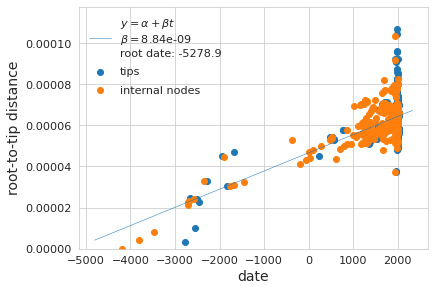

In [9]:
# RTT Regression
tt.plot_root_to_tip(add_internal=True, label=True)

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_rtt-pre." + FMT) 
plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

# 2. Filter Outliers

## Prune 'Bad' Branches from Tree

In [10]:
tt_pre = copy.deepcopy(tt)
tt_prune = copy.deepcopy(tt)

# Color branches and set to divtree
for n in tt_pre.tree.find_clades():
    n.branch_length=n.mutation_length
    if n.bad_branch:
        n.color = "red"
for n in tt_prune.tree.find_clades():
    n.branch_length=n.mutation_length

bad_nodes = [c for c in tt_prune.tree.find_clades() if c.bad_branch]

while len(bad_nodes) > 0:
    for node in bad_nodes:
        if node.is_terminal():
            print("PRUNING:", node.name)
            tt_prune.tree.prune(node)
    bad_nodes = [c for c in tt_prune.tree.find_clades() if c.bad_branch]

## Plot Prune Comparison: Divtree

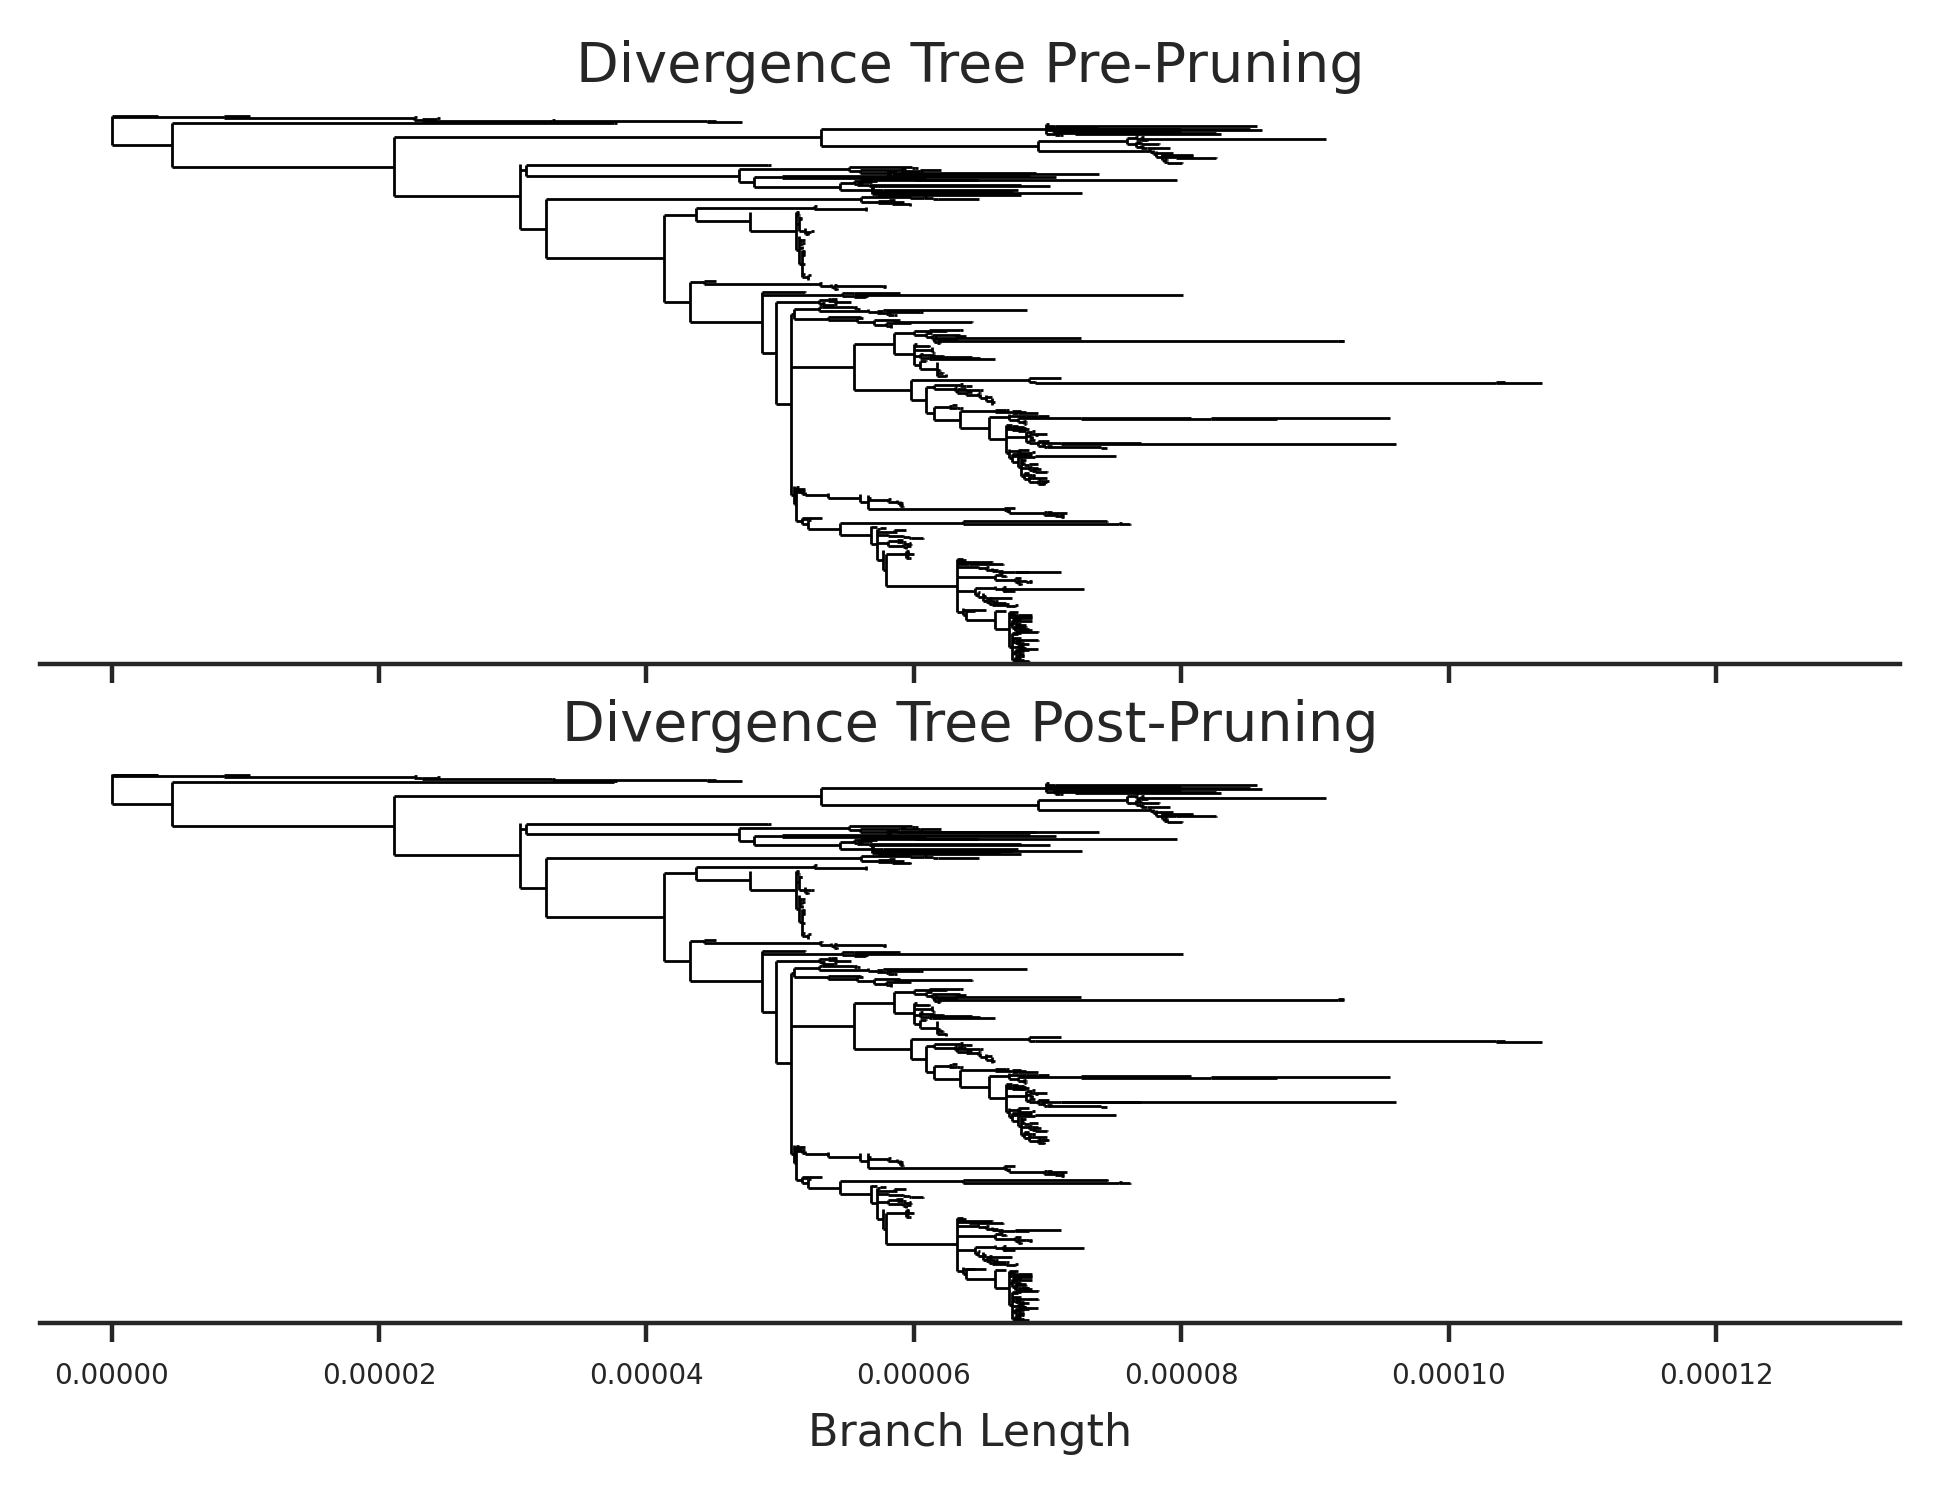

In [11]:
sns.set_style("ticks")
fig, (ax1,ax2) = plt.subplots(2, sharex=True, dpi=dpi)

Phylo.draw(tt_pre.tree,   show_confidence=False, label_func = lambda x: '', do_show=False, axes=ax1,)  
Phylo.draw(tt_prune.tree, show_confidence=False, label_func = lambda x: '', do_show=False, axes=ax2,)

ax1.set_title("Divergence Tree Pre-Pruning")
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_yticks([])
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["left"].set_visible(False)

ax2.set_title("Divergence Tree Post-Pruning")
ax2.set_xlabel("Branch Length")
ax2.set_ylabel("")
ax2.set_ylabel("")
ax2.set_yticks([])
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["left"].set_visible(False)

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_divtree-prune." + FMT) 
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

## Plot Prune Comparison: Timetree

160.40	--ClockTree.branch_length_to_years: setting node positions in units of
      	  years
172.18	--ClockTree.branch_length_to_years: setting node positions in units of
      	  years


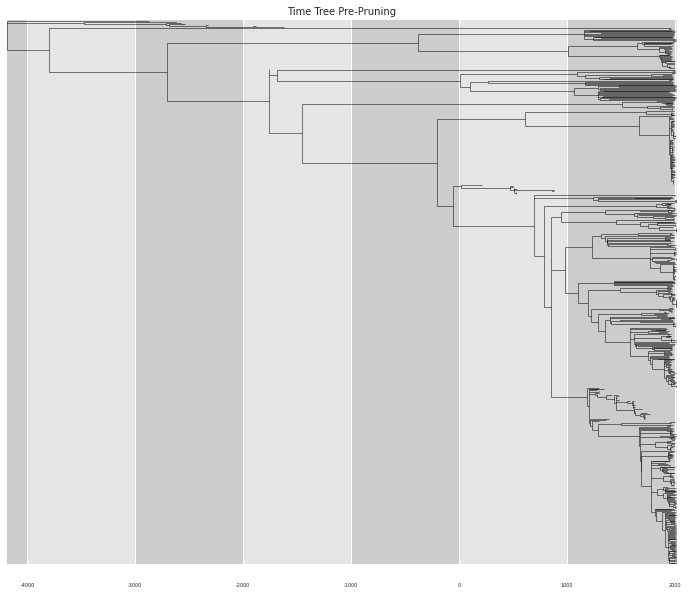

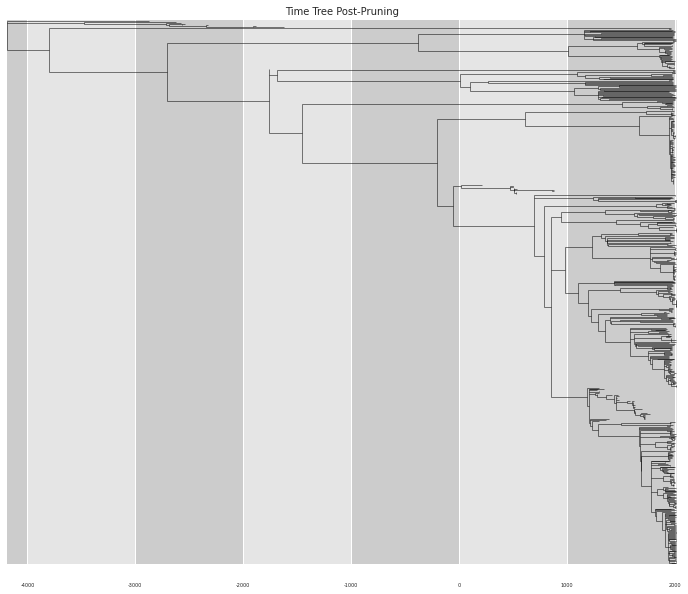

In [12]:
# Pre-pruning
if hasattr(tt.tree.root, "marginal_inverse_cdf"):
    fig, ax1 = treetime.treetime.plot_vs_years(tt_pre, label_func = lambda x:"", do_show=False, confidence=(1-CONFIDENCE, CONFIDENCE))
else:
    fig, ax1 = treetime.treetime.plot_vs_years(tt_pre, label_func = lambda x:"" ,do_show=False ,show_confidence=False)  

ax1.set_title("Time Tree Pre-Pruning")

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_timetree-prune-pre." + FMT) 
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

# Post-pruning    
if hasattr(tt.tree.root, "marginal_inverse_cdf"):
    fig, ax2 = treetime.treetime.plot_vs_years(tt_prune, label_func = lambda x:"", do_show=False, confidence=(1-CONFIDENCE, CONFIDENCE))
else:
    fig, ax2 = treetime.treetime.plot_vs_years(tt_prune, label_func = lambda x:"" ,do_show=False, show_confidence=False)  

ax2.set_title("Time Tree Post-Pruning")

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_timetree-prune-post." + FMT) 
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

## Update tt variable

In [13]:
tt = tt_prune

## Remove Collapsed Nodes from Dataframe

In [14]:
tt_nodes = [c.name for c in tt.tree.find_clades()]
for rec in tree_df.iterrows():
    node = rec[0]
    if node not in tt_nodes:
        tree_df.drop(node, inplace=True)
        
tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number
Name,,,,,,,,,,,,,,,,,,,,,
NODE0,100,NA,0.000000e+00,black,0.000000,17.820516,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA3541827,NA,NA,3.850400e-06,grey,0.000004,1.000000,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0
NODE1,100,85,1.327080e-05,black,0.000013,3.156250,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA104233046,NA,NA,2.248400e-06,grey,0.000016,2.000000,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0
NODE2,100,94.6,1.363640e-05,black,0.000027,4.312500,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCA_000269285.2_ASM26928v2_genomic,NA,NA,2.350000e-08,grey,0.000077,631.000000,PY-42,2010,-11,Peru,La Libertad,-6.86997,-75.0459,-8,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141470,KEEP: Assembly Modern,1
GCA_000269245.1_ASM26924v1_genomic,NA,NA,2.230000e-07,grey,0.000076,632.000000,PY-113,2010,-11,Peru,La Libertad,-6.86997,-75.0459,-8,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141506,KEEP: Assembly Modern,1
NODE631,37,49.6,2.936000e-07,black,0.000076,633.500000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


---
# 3. Add Clock Model to Dataframe

- Rates
- Dates
- RTT Regression
- Skyline
- coord_x and coord_y

## Rates

In [15]:
tree_df["timetree_rate"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_rate_fold_change"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_mutation_length"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

# The mean rate is the slope
mean_rate = tt.clock_model["slope"]

for c in tt.tree.find_clades():
    tree_df.at[c.name, "timetree_mutation_length"] = c.mutation_length
    
    # Relaxed Clock
    if hasattr(c, "branch_length_interpolator") and c.branch_length_interpolator:
        g = c.branch_length_interpolator.gamma
        tree_df.at[c.name, "timetree_rate_fold_change"] = g
        tree_df.at[c.name, "timetree_rate"] = mean_rate * g
        
    # Strict Clock
    else:
        tree_df.at[c.name, "timetree_rate_fold_change"] = 1
        tree_df.at[c.name, "timetree_rate"] = mean_rate

## Dates

In [16]:
# Create new columns
tree_df["timetree_raw_date"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_num_date"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

if hasattr(tt.tree.root, "marginal_inverse_cdf"):
    tree_df["timetree_num_date_confidence"] = [[NO_DATA_CHAR,NO_DATA_CHAR] for row in range(0,len(tree_df))]
    tree_df["timetree_num_date_bar"] = [[NO_DATA_CHAR,NO_DATA_CHAR] for row in range(0,len(tree_df))]
    
# clock_length is the same as branch_length until running branch_length_to_years()
tree_df["timetree_clock_length"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

# Make a copy to change branch_length
tt_copy = copy.deepcopy(tt)
tt_copy.branch_length_to_years()

CONF_BAD_RANGE = 10000
for c in tt_copy.tree.find_clades():
    # Marginal Probability
    if hasattr(c, "marginal_inverse_cdf"):   
        # Retrieve the region containing the confidence interval
        conf = tt.get_max_posterior_region(c, fraction=CONFIDENCE)
        conf_range = abs(conf[1] - conf[0])
        if conf_range > CONF_BAD_RANGE:
            print("Bad lower date estimated for:", c.name,"\t", conf_range, "\tSetting to", c.numdate)       
            conf[0] = c.numdate
            conf[1] = c.numdate
        
        # Set as lower and upper bounds on date
        tree_df.at[c.name, "timetree_num_date_confidence"][0] = conf[0]
        tree_df.at[c.name, "timetree_num_date_confidence"][1] = conf[1]
        
        # Convert to YBP present for drawing bars
        tree_df.at[c.name, "timetree_num_date_bar"][0] = CURRENT_YEAR - conf[0]
        tree_df.at[c.name, "timetree_num_date_bar"][1] = CURRENT_YEAR - conf[1]
        
    tree_df.at[c.name, "timetree_raw_date"] = c.date  
    tree_df.at[c.name, "timetree_num_date"] = c.numdate
    tree_df.at[c.name, "timetree_clock_length"] = c.branch_length

200.88	--ClockTree.branch_length_to_years: setting node positions in units of
      	  years


## RTT

In [17]:
# make a copy of the tree
tt_copy = copy.deepcopy(tt)
tt_copy.branch_length_to_years()

# Plotting the tree
tree_df["timetree_coord_x"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_coord_y"] = [NO_DATA_CHAR for row in range(0,len(tree_df))] 

# Plotting the regression
tree_df["timetree_reg_x"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_reg_y"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_reg_bad"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

x_posns = get_x_positions(tt_copy.tree)
y_posns = get_y_positions(tt_copy.tree)
tt_reg = tt_copy.setup_TreeRegression()

# Add x and y coordinates
for c in tt_copy.tree.find_clades():     
        
    # Tree Node Coordinates
    coord_x = [value for key,value in x_posns.items() if key.name == c.name][0]
    coord_y = [value for key,value in y_posns.items() if key.name == c.name][0]
    tree_df.at[c.name, 'timetree_coord_x'] = coord_x
    tree_df.at[c.name, 'timetree_coord_y'] = coord_y
    
    # Regression Node Coordinates
    reg_y = c._v
    if c.is_terminal():
        reg_x = tt_reg.tip_value(c)
    else:
        reg_x = c.numdate
    reg_bad = c.bad_branch  if hasattr(c, 'bad_branch') else False
    tree_df.at[c.name, 'timetree_reg_x'] = reg_x
    tree_df.at[c.name, 'timetree_reg_y'] = reg_y    
    tree_df.at[c.name, 'timetree_reg_bad'] = reg_bad

# Fix up new values that could be none
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df

201.36	--ClockTree.branch_length_to_years: setting node positions in units of
      	  years


,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number,timetree_rate,timetree_rate_fold_change,timetree_mutation_length,timetree_raw_date,timetree_num_date,timetree_clock_length,timetree_coord_x,timetree_coord_y,timetree_reg_x,timetree_reg_y,timetree_reg_bad
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NODE0,100,NA,0.000000e+00,black,0.000000,17.820516,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,8.842462e-09,1.0,0.000000e+00,-4188-05-11,-4187.642270,0.100000,0.100000,17.953153,-4187.642270,0.000000,False
SAMEA3541827,NA,NA,3.850400e-06,grey,0.000004,1.000000,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0,8.842462e-09,1.0,3.440042e-06,-2876-01-01,-2875.999887,1311.642383,1311.742383,1.000000,-2776.500000,0.000003,False
NODE1,100,85,1.327080e-05,black,0.000013,3.156250,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,8.842462e-09,1.0,8.391776e-06,-3477-10-31,-3476.169432,711.472838,711.572838,3.156250,-3476.169432,0.000008,False
SAMEA104233046,NA,NA,2.248400e-06,grey,0.000016,2.000000,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0,8.842462e-09,1.0,1.935113e-06,-2621-01-01,-2620.999887,855.169545,1566.742383,2.000000,-2546.500000,0.000010,False
NODE2,100,94.6,1.363640e-05,black,0.000027,4.312500,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,8.842462e-09,1.0,1.421721e-05,-2712-05-26,-2711.600341,764.569092,1476.141929,4.312500,-2711.600341,0.000023,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCA_000269285.2_ASM26928v2_genomic,NA,NA,2.350000e-08,grey,0.000077,631.000000,PY-42,2010,-11,Peru,La Libertad,-6.86997,-75.0459,-8,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141470,KEEP: Assembly Modern,1,8.842462e-09,1.0,1.518570e-21,2010-01-01,2010.000000,-0.000113,6197.742270,632.000000,2010.000000,0.000069,False
GCA_000269245.1_ASM26924v1_genomic,NA,NA,2.230000e-07,grey,0.000076,632.000000,PY-113,2010,-11,Peru,La Libertad,-6.86997,-75.0459,-8,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141506,KEEP: Assembly Modern,1,8.842462e-09,1.0,2.148891e-07,2010-01-01,2010.000000,58.878358,6197.742270,628.000000,2010.000000,0.000068,False
NODE631,37,49.6,2.936000e-07,black,0.000076,633.500000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,8.842462e-09,1.0,2.148968e-07,1969-03-15,1969.200350,18.078708,6156.942620,633.500000,1969.200350,0.000068,False


## Divergence coord_x and coord_y

In [18]:
tt_copy = copy.deepcopy(tt)
for n in tt_copy.tree.find_clades():
    n.branch_length=n.mutation_length
    
x_posns = get_x_positions(tt_copy.tree)
y_posns = get_y_positions(tt_copy.tree)

# Add x and y coordinates as other attributes
for c in tt_copy.tree.find_clades():
    # x coordinates will be of branch length units
    coord_x = [value for key,value in x_posns.items() if key.name == c.name][0]
    # y coordinates will be arbitrary, based on number of tips
    coord_y = [value for key,value in y_posns.items() if key.name == c.name][0]
    # Update coordinates in dataframe
    tree_df.at[c.name, 'coord_x'] = coord_x
    tree_df.at[c.name, 'coord_y'] = coord_y    

# Visualize dataframe
tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number,timetree_rate,timetree_rate_fold_change,timetree_mutation_length,timetree_raw_date,timetree_num_date,timetree_clock_length,timetree_coord_x,timetree_coord_y,timetree_reg_x,timetree_reg_y,timetree_reg_bad
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NODE0,100,NA,0.000000e+00,black,0.000000,17.953153,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,8.842462e-09,1.0,0.000000e+00,-4188-05-11,-4187.642270,0.100000,0.100000,17.953153,-4187.642270,0.000000,False
SAMEA3541827,NA,NA,3.850400e-06,grey,0.000003,1.000000,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0,8.842462e-09,1.0,3.440042e-06,-2876-01-01,-2875.999887,1311.642383,1311.742383,1.000000,-2776.500000,0.000003,False
NODE1,100,85,1.327080e-05,black,0.000008,3.156250,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,8.842462e-09,1.0,8.391776e-06,-3477-10-31,-3476.169432,711.472838,711.572838,3.156250,-3476.169432,0.000008,False
SAMEA104233046,NA,NA,2.248400e-06,grey,0.000010,2.000000,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0,8.842462e-09,1.0,1.935113e-06,-2621-01-01,-2620.999887,855.169545,1566.742383,2.000000,-2546.500000,0.000010,False
NODE2,100,94.6,1.363640e-05,black,0.000023,4.312500,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,8.842462e-09,1.0,1.421721e-05,-2712-05-26,-2711.600341,764.569092,1476.141929,4.312500,-2711.600341,0.000023,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCA_000269285.2_ASM26928v2_genomic,NA,NA,2.350000e-08,grey,0.000069,632.000000,PY-42,2010,-11,Peru,La Libertad,-6.86997,-75.0459,-8,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141470,KEEP: Assembly Modern,1,8.842462e-09,1.0,1.518570e-21,2010-01-01,2010.000000,-0.000113,6197.742270,632.000000,2010.000000,0.000069,False
GCA_000269245.1_ASM26924v1_genomic,NA,NA,2.230000e-07,grey,0.000068,628.000000,PY-113,2010,-11,Peru,La Libertad,-6.86997,-75.0459,-8,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141506,KEEP: Assembly Modern,1,8.842462e-09,1.0,2.148891e-07,2010-01-01,2010.000000,58.878358,6197.742270,628.000000,2010.000000,0.000068,False
NODE631,37,49.6,2.936000e-07,black,0.000068,633.500000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,8.842462e-09,1.0,2.148968e-07,1969-03-15,1969.200350,18.078708,6156.942620,633.500000,1969.200350,0.000068,False


## Skyline

In [19]:
if hasattr(tt, "merger_model"):
    #skyline, conf = tt.merger_model.skyline_inferred(gen=50, confidence=N_STD)
    #print(skyline)
    #print(conf)
    out_path_skyline_pdf = os.path.join(outdir, SCRIPT_NAME + "_skyline." + FMT )
    out_path_skyline_txt = os.path.join(outdir, SCRIPT_NAME + "_skyline.tsv" )
    treetime.wrappers.print_save_plot_skyline(tt, 
                                              plot=out_path_skyline_pdf, 
                                              save=out_path_skyline_txt,
                                              screen=True,
                                              n_std=2.0, )

## Add Metadata as Comments

In [20]:
metadata_to_comment(tt.tree, tree_df)

---
# Export

## Dataframe

In [21]:
# Dataframe
out_path_df = os.path.join(outdir, SCRIPT_NAME + ".tsv" )
out_path_pickle_df = os.path.join(outdir,  SCRIPT_NAME + ".df.obj" )

tree_df.to_csv(out_path_df, sep="\t")
with open(out_path_pickle_df,"wb") as outfile:
    dill.dump(tree_df, outfile)

## Timetrees

In [26]:
tt_copy = copy.deepcopy(tt)

# Nexus
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + "_timetree.nexus" )
Phylo.write(tt_copy.tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

# Dill object
out_path_dill_tree = os.path.join(outdir,  SCRIPT_NAME + "_timetree.treetime.obj" )
with open(out_path_dill_tree,"wb") as outfile:
    dill.dump(tt_copy, outfile)
    
# Newick (remove comments)
for c in tt_copy.tree.find_clades(): c.comment = None
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + "_timetree.nwk" )
Phylo.write(tt_copy.tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))


1

## Divtrees

In [28]:
tt_copy = copy.deepcopy(tt)
# Convert to divtree
for n in tt_copy.tree.find_clades():
    n.branch_length=n.mutation_length

# Nexus
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + "_divtree.nexus" )
Phylo.write(tt_copy.tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

# Dill object
out_path_dill_tree = os.path.join(outdir,  SCRIPT_NAME + "_divtree.treetime.obj" )
with open(out_path_dill_tree,"wb") as outfile:
    dill.dump(tt_copy, outfile)
    
# Newick (remove comments)
for c in tt_copy.tree.find_clades(): c.comment = None
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + "_divtree.nwk" )
Phylo.write(tt_copy.tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

1

## Augur JSON

In [29]:
augur_dict = augur_export(
    tree_path=out_path_nwk, 
    aln_path=aln_path, 
    tree=tt.tree,     
    #tree=tree_div, 
    tree_df=tree_df, 
    color_keyword_exclude=["color", "coord", "reg", "lat", "lon"],
    type_convert = {
        "Branch_Number" : (lambda x : str(x))
    },
)

print(augur_dict["nodes"]["Reference"])

if hasattr(tt, "merger_model"):
    skyline, conf = tt.merger_model.skyline_inferred(gen=50, confidence=2)
    augur_dict['skyline'] = [[float(x) for x in skyline.x], [float(y) for y in conf[0]],
                           [float(y) for y in skyline.y], [float(y) for y in conf[1]]]

out_path_augur_json = os.path.join(outdir, SCRIPT_NAME + "_augur.json" )
utils.write_json(data=augur_dict, file_name=out_path_augur_json, indent=JSON_INDENT)

{'ufboot': 'NA', 'scf': 'NA', 'branch_length': 1.8768e-06, 'strain': 'NA', 'date': 1992.0, 'datebp': -29.0, 'country': 'United States of America', 'province': 'Colorado', 'biovar': 'Orientalis', 'branch_major': '1.ORI', 'branch_minor': '1.ORI1', 'biosample': 'NA', 'biosamplecomment': 'KEEP: Assembly Modern Reference', 'branch_number': '1', 'rate': 8.8424622323936e-09, 'rate_fold_change': 1.0, 'mutation_length': 1.7200897264101546e-06, 'raw_date': '1992-01-01', 'num_date': 1992.0, 'clock_length': 44.858383081334296}


## Auspice JSON

In [30]:
auspice_dict = auspice_export(
    tree=tt.tree, 
    augur_json_paths=[out_path_augur_json], 
    auspice_config_path=auspice_config_path, 
    auspice_colors_path=auspice_colors_path,
    auspice_latlons_path=auspice_latlon_path, 
    )

# Write outputs - For Local Rendering
out_path_auspice_local_json = os.path.join(outdir, SCRIPT_NAME + "_auspice.json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_local_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_local_json)
print("Validation successful for local JSON.")

# Write outputs - For Remote Rendering
out_path_auspice_remote_json = os.path.join(auspice_remote_dir_path, AUSPICE_PREFIX + SCRIPT_NAME.replace("_","-") + ".json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_remote_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_remote_json)
print("Validation successful for remote JSON.")

<class 'dict'>
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/config/auspice_config.json'...
Validation success.


Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/clock/all/chromosome_filter5/clock_model_auspice.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/clock/all/chromosome_filter5/clock_model_auspice.json' succeeded.
Validation successful for local JSON.
Validating produced JSON
Validating schema of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/auspice/plague-phylogeography_clock-model.json'...
Validating that the JSON is internally consistent...
Validation of '/mnt/c/Users/ktmea/Projects/plague-phylogeography/auspice/plague-phylogeography_clock-model.json' succeeded.
Validation successful for remote JSON.
